## Projection onto constrained non-axis-aligned ellipsoid

The nearest non-axis-aligned ellipsoid (parametrized by $(a, b, c, \theta, \phi, \psi)$), with unit surface area, to the set of points $\{\mathbf x_i\}$ can be found in the least-squares sense,

$$
\begin{array}{ll}
  \underset{\text {over } a,b,c,\theta,\phi,\psi}{\text{minimize}} & \sum_{i=1}^{m} \left({\mathbf x_i}^\top \mathbf {Q\Lambda Q^\top } \mathbf x_i - 1\right)^2 \\
  \text{subject to} & 4 \pi \sqrt[p]{\frac{(ab)^p + (ac)^p + (bc)^p}{3}} = 1
\end{array}
$$

which can be written in standard form as

$$
\begin{array}{ll}
  \text{minimize} & \| \text{diag}( \mathbf {X^\top Q\Lambda Q^\top X}) - \mathbf{1}_m\|^2 \\
  \text{subject to} & 4 \pi \sqrt[p]{\frac{1}{3} \left[ \left(\frac{1}{\sqrt{u_1u_2}}\right)^p + \left(\frac{1}{\sqrt{u_1u_3}}\right)^p + \left(\frac{1}{\sqrt{u_2u_3}}\right)^p \right]  } = 1
\end{array}
$$

where

$$
\mathbf X = \begin{bmatrix}
  | & \cdots & | \\
  \mathbf x_1 & \cdots & \mathbf x_m \\
  | & \cdots & |
\end{bmatrix}
$$

and $u = \left(1/a^2,1/b^2,1/c^2\right)^\top = \left(\lambda_1, \lambda_2, \lambda_3\right)^\top$.


<!-- Note that if $A$ can be decomposed by an eigendecomposition into $A = U^\top  \Lambda U$ where $U$ is an orthonormal rotation matrix and $\Lambda$ is a diagonal matrix of eigenvalues, then it is valid. -->


## Bilevel optimization

Our overall problem can then be stated as

$$
\begin{array}{ll}
  \text{minimize (over $\{(x_i, y_i)\}$)} & \sqrt{u_1^\star u_2^\star u_3^\star} \\
  \text{subject to} & u^\star = \text{argmin} \; \| \text{diag}(X^\top Q\Lambda Q^\top  X) - \mathbf{1}_m\|^2 \\
  & \hphantom{y =} \text{subject to} \; 4 \pi \sqrt[p]{\frac{1}{3} \left[ \left(\frac{1}{\sqrt{u_1u_2}}\right)^p + \left(\frac{1}{\sqrt{u_1u_3}}\right)^p + \left(\frac{1}{\sqrt{u_2u_3}}\right)^p \right]  } -1=0
\end{array}
$$

where we have stated the lower-level problem in terms of $u$ rather than $(a, b, c)$, and therefore instead of maximizing $\frac{4}{3} \pi a b c$, we minimize $\sqrt{u_1 u_2 u_2} = \frac{1}{abc}$.

In [1]:
import math
import numpy as np
from torch import cos, sin
import scipy.optimize as opt
import torch
import torch.nn as nn
%matplotlib ipympl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../../../ddn/")
from ddn.pytorch.node import *

from pytorch3d.loss import chamfer_distance
from pytorch3d.ops import sample_farthest_points
import alphashape
from descartes import PolygonPatch


In [2]:
# ellipse area and circumferencce
def ellipsoid_volume(a, b,c):
    """Returns the volume of an ellipsoid parametrized as (x/a)^2 + (y/b)^2 + (z/c)^2 = 1."""
    return 4/3 * torch.pi * a * b * c

def ellipsoid_surface_area(a, b, c, p=1.6075):
    """Returns the approximate surface area of an ellipsoid."""
    a_p = a**p
    b_p = b**p
    c_p = c**p
    return 4 * torch.pi * (1/3 * (a_p*b_p + a_p*c_p + b_p*c_p))**(1/p)


def rotation_matrix_3d(angles):
    alpha, beta, gamma = angles[0], angles[1], angles[2] # yaw, pitch, roll
    R = torch.stack([
        torch.stack([cos(alpha)*cos(beta), cos(alpha)*sin(beta)*sin(gamma)-sin(alpha)*cos(gamma), cos(alpha)*sin(beta)*cos(gamma)+sin(alpha)*sin(gamma)]),
        torch.stack([sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma)+cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma)-cos(alpha)*sin(gamma)]),
        torch.stack([-sin(beta), cos(beta)*sin(gamma), cos(beta)*cos(gamma)])
    ])
    return R

def generate_ellipsoid_coords(sqrt_m, a, b, c, yaw, pitch, roll):
    phi = 2.0 * math.pi * torch.linspace(0.0, 1.0, sqrt_m).double()
    theta = math.pi * torch.linspace(0.00, 1.0, sqrt_m).double()
    phi, theta = torch.meshgrid(phi, theta)
    x = a * torch.sin(theta) * torch.cos(phi)
    y = b * torch.sin(theta) * torch.sin(phi)
    z = c * torch.cos(theta)
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()
    coords = torch.stack((x_flat, y_flat, z_flat), dim=0).double()
    angles = torch.tensor([yaw, pitch, roll], requires_grad=True, dtype=torch.float)
    rotation_matrix = rotation_matrix_3d(torch.deg2rad(angles)).double()
    rotated_coords = rotation_matrix @ coords
    return rotated_coords

def plot_ellipsoid(ax, a, b, c, yaw, pitch, roll, color='blue', linestyle='-', linewidth=0.5, alpha=0.5, sqrt_m=25):
    coords = generate_ellipsoid_coords(sqrt_m, a, b, c, yaw, pitch, roll).T.detach()
    x_rot = coords[:, 0].reshape(sqrt_m,sqrt_m)
    y_rot = coords[:, 1].reshape(sqrt_m,sqrt_m)
    z_rot = coords[:, 2].reshape(sqrt_m,sqrt_m)
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')

    ax.plot_wireframe(x_rot.numpy(), y_rot.numpy(), z_rot.numpy(),
                      color=color, linestyle=linestyle, linewidth=linewidth, alpha=alpha)
    ax.set_aspect('equal', adjustable='box')

def generate_data(sqrt_m, m, a, b, c, yaw, pitch, roll, nu, p):
    coords = generate_ellipsoid_coords(sqrt_m, a, b, c, yaw, pitch, roll).detach()
    data = coords + nu * torch.randn(3, m, dtype=torch.double)
    data = data.unsqueeze(0)
    return data

def constraint_function(u, p=1.6075):
    if not torch.is_tensor(u):
        u = torch.tensor(u)
    a = u[0]
    b = u[1]
    c = u[2]
    res = 4/3 * torch.pi * (a*b*c) - 1
    return res

def constraint_function_grad(u):
    if torch.is_tensor(u):
        u = u.detach().clone()
    else:
        u = torch.tensor(u)
    u.requires_grad = True
    with torch.enable_grad():
        res = constraint_function(u)
    constr_grad = torch.autograd.grad(res, u)[0]
    return constr_grad

def objective_function(u, X, u_prev=None):
    if not torch.is_tensor(u):
        u = torch.tensor(u).double()
    if not torch.is_tensor(X):
        X = torch.tensor(X).double()
    L = torch.diag(1/u[:3]**2).double()
    R = rotation_matrix_3d(u[3:6]).double() # assumes radians
    A = R @ L @ R.T
    XT_AX = torch.einsum('ji,jk,ki->i', X, A, X)
    b = torch.ones(X.shape[1])
    if u_prev is None:
        u_prev = u 
    elif not torch.is_tensor(u_prev):   
        u_prev = torch.tensor(u_prev).double()
    return torch.sum((XT_AX - b) ** 2)/100 + torch.norm(u_prev - u)**2/100

def objective_function_grad(u, X, u_prev=None):
    if torch.is_tensor(u):
        u = u.detach().clone()
    else:
        u = torch.tensor(u)
    if torch.is_tensor(X):
        X = X.detach().clone()
    else:
        X = torch.tensor(X).double()
    if u_prev is not None:
        if torch.is_tensor(u_prev):
            u_prev = u_prev.detach().clone()
        else:
            u_prev = torch.tensor(u_prev)
    else:
        u_prev = u
    u.requires_grad = True
    with torch.enable_grad():
        res = objective_function(u, X, u_prev).double()
    obj_grad = torch.autograd.grad(res, u)[0].double()
    return obj_grad

# ellipse fitting
def fit_ellipsoid(xs, p=1.6075, method="default", with_jac=False, u_prev=None):
    """Find ellipsoid parameters u = (1/a^2, 1/b^2, 1/c^2) that best fit the data."""
    n_batches = xs.size(0)
    results = torch.zeros(n_batches, 6, dtype=torch.double)
    losses = torch.zeros(n_batches, 1, dtype=torch.double)
    for batch_number, x in enumerate(xs):
        X = x.detach().numpy()
        if u_prev is not None:
            u0 = u_prev[batch_number].detach().numpy()
        else:
            u0 = initialise_u(X, method)
        if with_jac:
            eq_const = {'type': 'eq',
                        'fun' : lambda u: constraint_function(u).cpu().numpy(),
                        'jac' : lambda u: constraint_function_grad(u).cpu().numpy()
                        }
            ineq_const = {'type': 'ineq',
                        'fun' : lambda u: np.array([2*np.pi - u[3], 2*np.pi - u[4], 2*np.pi - u[5], u[3], u[4], u[5]])}
            res = opt.minimize(lambda u: objective_function(u, X, u_prev).detach().cpu().numpy(), u0, jac=lambda u: objective_function_grad(u,X, u_prev).cpu().numpy(), 
                            method='SLSQP', constraints=[eq_const, ineq_const],
                            options={'ftol': 1e-9, 'disp': False, 'maxiter': 200})
        else:
            eq_const = {'type': 'eq',
                        'fun' : lambda u: constraint_function(u).cpu().numpy(),
                        }
            ineq_const = {'type': 'ineq',
                        'fun' : lambda u: np.array([2*np.pi - u[3], 2*np.pi - u[4], 2*np.pi - u[5], u[3], u[4], u[5]])}
            res = opt.minimize(lambda u: objective_function(u, X, u_prev).detach().cpu().numpy(), u0,
                            method='SLSQP', constraints=[eq_const, ineq_const],
                            options={'ftol': 1e-9, 'disp': False, 'maxiter': 200})
        if not res.success:
            print("FIT failed:", res.message)
        results[batch_number] = torch.tensor(res.x, dtype=torch.double, requires_grad=True)
        losses[batch_number] = torch.tensor(res.fun, dtype=torch.double, requires_grad=False)
    return results, losses


def initialise_u(data, method):
    if method == "default": # random initialisation
        u0 = np.ones(6)
    elif method == "bb":
        h,w,l = get_bounding_box_dims(data)/2
        u0 = np.zeros(6)
        u0[:3] = np.array([h,w,l])
        u0[3:] = np.random.uniform(low=0, high=90, size=3)
    elif method == "pca":
        u0 = pca(data)
    return u0

def get_angles(rotation):
    pitch = - np.arcsin(rotation[2,0])
    denom = 1/np.sqrt(1 - (rotation[2,0] ** 2))
    roll = np.arctan2(rotation[2,1]/denom, rotation[2,2]/denom)
    yaw = np.arctan2(rotation[1,0]/denom, rotation[0,0]/denom)
    return np.rad2deg([yaw, pitch, roll])

def pca(data):
    """
    Get three dominant axes of data along with angles
    """
    data = data.T
    pca = PCA(n_components=3)
    pca.fit(data)
    semiaxes = np.sqrt(pca.explained_variance_ * np.array([2,4,4]))
    rotation = np.fliplr(pca.components_)
    angles = np.array(get_angles(rotation))
    u0 = np.concatenate([semiaxes, angles])
    return u0
    
def extract_params(u):
    if torch.any(u) < 0:
        print("WARNING: Negative axes lengths.")
    a, b, c = (torch.abs(u[:3])).tolist()
    yaw, pitch, roll = np.rad2deg(u[3:].tolist()) % 360
    return a,b,c,yaw,pitch,roll

def get_bounding_box_dims(points):
    min_x, min_y, min_z = np.min(points, axis=1)
    max_x, max_y, max_z = np.max(points, axis=1)

    # Calculate the dimensions of the bounding box
    height = max_z - min_z
    width = max_x - min_x
    length = max_y - min_y
    return np.sort([height, width, length])

def plot_points(ax, data, color, alpha):
    x,y,z = data[0,0:3].detach().numpy()
    ax.scatter(x,y,z, color=color, alpha=alpha, s=1)

def inner_problem(semiaxes, angles, sqrt_m, nu, p, method="default", with_jac=False):
    m = sqrt_m * sqrt_m
    if method=="pca":
        sorted_params = sorted(zip(semiaxes, angles), key=lambda u: u[0])
        semiaxes, angles = zip(*sorted_params)
    a, b, c = semiaxes
    yaw, pitch, roll = np.array(angles)
    print(f"Ellipsoid (blue) ({a:0.3}, {b:0.3}, {c:0.3}, {float(yaw):0.3}\N{DEGREE SIGN}, {float(pitch):0.3}\N{DEGREE SIGN}, {float(roll):0.3}\N{DEGREE SIGN}) has volume {ellipsoid_volume(a, b, c):0.3} and surface area {ellipsoid_surface_area(a, b, c, p):0.3}")

    data = generate_data(sqrt_m, m, a, b, c, yaw, pitch, roll, nu, p)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_ellipsoid(ax, a, b, c, yaw, pitch, roll, color='b')
    plot_points(ax, data, 'b', 0.8)

    u,l = fit_ellipsoid(data, p, method, with_jac)
    a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat = extract_params(u.squeeze().detach())
    plot_ellipsoid(ax, a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat, color='r')
    print(f"Ellipsoid (red) ({a_hat:0.3}, {b_hat:0.3}, {c_hat:0.3}, {(yaw_hat):0.4}\N{DEGREE SIGN}, {(pitch_hat):0.4}\N{DEGREE SIGN}, {(roll_hat):0.4}\N{DEGREE SIGN}) has volume {ellipsoid_volume(a_hat, b_hat, c_hat):0.3} and surface area {ellipsoid_surface_area(a_hat, b_hat, c_hat, p):0.3}")
    plt.show()

    return m, data, np.array([a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat])

In [3]:
# sample a noisy ellipse
sqrt_m = 100
a, b, c = 0.5, 0.6, 0.7
yaw, pitch, roll =  0, 30, 30

nu = 1.0e-4
p = 1.6075
print(f"Ellipsoid (blue) ({a:0.3}, {b:0.3}, {c:0.3}, {float(yaw):0.3}\N{DEGREE SIGN}, {float(pitch):0.3}\N{DEGREE SIGN}, {float(roll):0.3}\N{DEGREE SIGN}) has volume {ellipsoid_volume(a, b, c):0.3} and surface area {ellipsoid_surface_area(a, b, c, p):0.3}")
m = sqrt_m * sqrt_m

data = generate_data(sqrt_m, m, a, b, c, yaw, pitch, roll, nu, p)
u,l = fit_ellipsoid(data, p)
a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat = extract_params(u.squeeze().detach())
points = generate_data(sqrt_m, m, a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat, nu, p).mT.squeeze().numpy()
print(f"Ellipsoid (red) ({a_hat:0.3}, {b_hat:0.3}, {c_hat:0.3}, {(yaw_hat):0.4}\N{DEGREE SIGN}, {(pitch_hat):0.4}\N{DEGREE SIGN}, {(roll_hat):0.4}\N{DEGREE SIGN}) has volume {ellipsoid_volume(a_hat, b_hat, c_hat):0.3} and surface area {ellipsoid_surface_area(a_hat, b_hat, c_hat, p):0.3}")

print("Volume is ", ellipsoid_volume(a,b,c))

Ellipsoid (blue) (0.5, 0.6, 0.7, 0.0°, 30.0°, 30.0°) has volume 0.88 and surface area 4.51
Ellipsoid (red) (0.53, 0.638, 0.705, 4.229e-19°, 30.0°, 210.0°) has volume 1.0 and surface area 4.89
Volume is  0.8796459430051419


In [6]:
import open3d as o3d
import trimesh
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.normals = o3d.utility.Vector3dVector(points)

# Alpha shape (ball-pivoting-like method)
alpha = 0.03  # Adjust this parameter
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(5, 30, 0.1)

# Create a mesh using Poisson reconstruction
# radii = [0.01 * x for x in range(1,100)] + [10]
# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
#     pcd, o3d.utility.DoubleVector(radii))

# Visualize
# o3d.visualization.draw_geometries([mesh])

alpha = 0.8  # Adjust this parameter
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)

# o3d.visualization.draw_geometries([mesh])

def o3d_to_trimesh(o3d_mesh):
    vertices = np.asarray(o3d_mesh.vertices)
    faces = np.asarray(o3d_mesh.triangles)
    vertex_normals = np.asarray(o3d_mesh.vertex_normals) if o3d_mesh.has_vertex_normals() else None

    mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=vertex_normals)
    return mesh

mesh_trimesh = o3d_to_trimesh(mesh)

# Visualize Trimesh
# mesh_trimesh.show()

vec = np.column_stack((mesh_trimesh.vertices, mesh_trimesh.vertices + (mesh_trimesh.vertex_normals * mesh_trimesh.scale * .05)))
path = trimesh.load_path(vec.reshape((-1, 2, 3)))

trimesh.Scene([mesh_trimesh, path]).show(smooth=False)


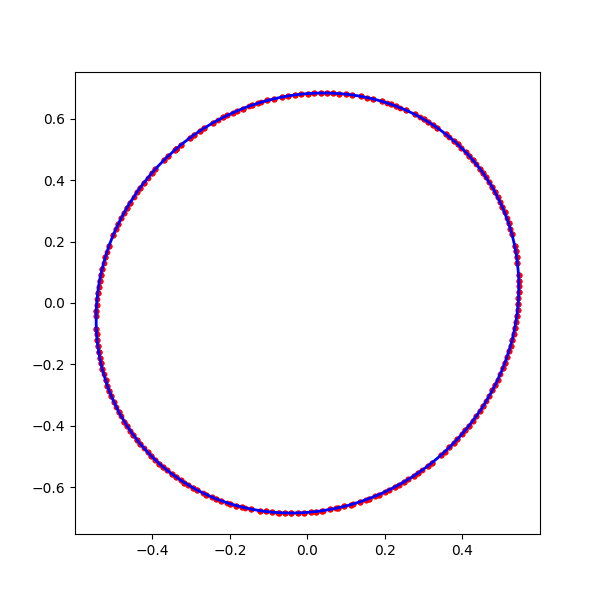

In [7]:
boundary = np.array((trimesh.path.polygons.projected(mesh_trimesh, [2,5,10]).exterior.coords))
plt.figure(figsize=(6, 6))
plt.plot(boundary[:, 0], boundary[:, 1], 'b-', linewidth=2)  # Blue boundary
plt.scatter(boundary[:, 0], boundary[:, 1], color='red', s=10)  # Red points


In [8]:
import torch
from pytorch3d.structures import Meshes

def get_signed_tet_volume(face_vertices: torch.Tensor) -> torch.Tensor:
    """
    Compute signed tetrahedron volumes for a batch of faces.

    Args:
        face_vertices (torch.Tensor): Tensor of shape (F, 3, 3), where
                                      F is the number of faces, and each face
                                      consists of 3 vertices in 3D.

    Returns:
        torch.Tensor: A tensor of shape (F,) containing signed volumes.
    """
    v0, v1, v2 = face_vertices[:, 0, :], face_vertices[:, 1, :], face_vertices[:, 2, :]
    
    # Compute determinant of the 3x3 matrix [v0, v1, v2]
    volumes = torch.det(torch.stack([v0, v1, v2], dim=-1)) / 6.0  # Shape: (F,)

    return volumes

def get_volume_batch(meshes: Meshes):
    verts_packed = meshes.verts_packed()  # (sum(V_i), 3)
    faces_packed = meshes.faces_packed()  # (sum(F_i), 3)
    mesh_to_face = meshes.mesh_to_faces_packed_first_idx()  # Index of first face per mesh
    n_meshes = len(meshes)
    volumes = torch.zeros(n_meshes, device=verts_packed.device)

    for i in range(n_meshes):
        start = mesh_to_face[i]
        end = start + meshes.num_faces_per_mesh()[i]
        face_vertices = verts_packed[faces_packed[start:end]]  # (F, 3, 3)
        volumes[i] = get_signed_tet_volume(face_vertices).sum()  # Sum over all faces

    return volumes  # Returns a tensor of shape (num_meshes,)


def get_volume_scatter_add(meshes: Meshes):
    verts_packed = meshes.verts_packed()  # (sum(V_i), 3)
    faces_packed = meshes.faces_packed()  # (sum(F_i), 3)
    
    face_vertices = verts_packed[faces_packed]  # (sum(F_i), 3, 3)
    face_volumes = get_signed_tet_volume(face_vertices)  # (sum(F_i),)
    n_meshes = len(meshes)

    # Sum per mesh using torch_scatter
    volumes = torch.zeros(n_meshes, device=verts_packed.device, dtype=face_volumes.dtype)
    volumes.scatter_add_(0, meshes.faces_packed_to_mesh_idx(), face_volumes)
    return volumes  # Shape: (num_meshes,)

In [9]:
verts = torch.tensor(mesh_trimesh.vertices, dtype=torch.float64)
faces = torch.tensor(mesh_trimesh.faces, dtype=torch.int64)

# Convert to PyTorch3D Meshes object (single-batch)
meshes = Meshes(verts=[verts], faces=[faces])

get_volume_scatter_add(meshes)

tensor([0.9991], dtype=torch.float64)